In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers,initializers
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython import display
import random
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import sys

In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')

In [4]:
pus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)  # 设置显存按需申请
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)]) 

In [5]:
seq_len = 30
num_singal = 29
seq_step = 1
value = 0
width = num_singal
height = seq_len
channels = 1
epoch_dura = 1
owner="D"
feature="29"
dp=591

In [6]:
def pca(samples):
    X_n = samples
    ####################################
    ###################################
    # -- the best PC dimension is chosen pc=6 -- #
    n_components = num_singal
    pca = PCA(n_components)
    pca.fit(X_n)
    T_n = pca.transform(X_n)
    ex_var = pca.explained_variance_ratio_
    pc = pca.components_
    # projected values on the principal component
    T_n = np.matmul(X_n, pc.transpose(1, 0))
    samples = T_n
    return samples

In [7]:
def norm(train):
    m, n = train.shape  # m=562387, n=35
    # normalization
    for i in range(n):
        # print('i=', i)
        A = max(train[:, i])-min(train[:, i])
        if A != 0:
#             train[:,i] = train[:,i]-train[:,i].mean()
#             train[:,i] = train[:,i]/train[:,i].std()
            train[:,i] = (train[:,i]-train[:,i].min())/(train[:,i].max()-train[:,i].min())           
#             train[:,i] = train[:,i]*(train[:,i].max()-train[:,i].min())+train[:,i].min()
#             train[:, i] /= max(train[:, i])
#             # scale from -1 to 1
#             train[:, i] = 2 * train[:, i] - 1
        else:
            train[:, i] = train[:, i]
    return train

In [8]:
# scaler = MinMaxScaler()
# train_data=np.load('./data/data'+owner+'_cityroad_29.npy',allow_pickle=True)
# train_data1 = scaler.fit_transform(train_data)
# train_data1 = pca(train_data1)
# ####################test data################################
# test_data1=np.load('./data/dataA_highway_29.npy',allow_pickle=True)
# test_data1 = scaler.fit_transform(test_data1)
# test_data1 = pca(test_data1)

# test_data2=np.load('./data/dataB_highway_29.npy',allow_pickle=True)
# test_data2 = scaler.fit_transform(test_data2)
# test_data2 = pca(test_data2)

# test_data3=np.load('./data/dataC_highway_29.npy',allow_pickle=True)
# test_data3 = scaler.fit_transform(test_data3)
# test_data3 = pca(test_data3)

# test_data = np.vstack((test_data1,test_data2))
# test_data = np.vstack((test_data,test_data3))
# #############################################################
# train_data_driver = train_data1
# train_data_drivertest = np.load('./data/data'+owner+'_highway_29.npy',allow_pickle=True)
# train_data_drivertest = scaler.fit_transform(train_data_drivertest)
# train_data_drivertest =pca(train_data_drivertest)

In [9]:
# scaler = MinMaxScaler()
# train_data=np.load('./data/dataD_cityroad_29.npy',allow_pickle=True)
# train_data1 = scaler.fit_transform(train_data)
# train_data1 = pca(train_data1)
# ####################test data################################
# test_data1=np.load('./data/dataA_'+feature+'.npy',allow_pickle=True)
# test_data1 = scaler.fit_transform(test_data1)
# test_data1 = pca(test_data1)

# test_data2=np.load('./data/dataB_'+feature+'.npy',allow_pickle=True)
# test_data2 = scaler.fit_transform(test_data2)
# test_data2 = pca(test_data2)

# test_data3=np.load('./data/dataC_'+feature+'.npy',allow_pickle=True)
# test_data3 = scaler.fit_transform(test_data3)
# test_data3 = pca(test_data3)

# test_data = np.vstack((test_data1,test_data2))
# test_data = np.vstack((test_data,test_data3))
# #############################################################
# train_data_driver = train_data1
# train_data_drivertest = np.load('./data/dataD_highway_29.npy',allow_pickle=True)
# train_data_drivertest = scaler.fit_transform(train_data_drivertest)
# train_data_drivertest =pca(train_data_drivertest)

In [10]:
# train_data_drivertest.shape

In [11]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
train_data=np.load('./data/dataD_'+feature+'.npy',allow_pickle=True)
train_data1 = scaler.fit_transform(train_data)
train_data1 = pca(train_data1)
####################test data################################
test_data1=np.load('./data/dataA_'+feature+'.npy',allow_pickle=True)
test_data1 = scaler.fit_transform(test_data1)
test_data1 = pca(test_data1)

test_data2=np.load('./data/dataB_'+feature+'.npy',allow_pickle=True)
test_data2 = scaler.fit_transform(test_data2)
test_data2 = pca(test_data2)

test_data3=np.load('./data/dataC_'+feature+'.npy',allow_pickle=True)
test_data3 = scaler.fit_transform(test_data3)
test_data3 = pca(test_data3)

test_data = np.vstack((test_data1,test_data2))
test_data = np.vstack((test_data,test_data3))
#############################################################

train_data_driver = train_data1[:train_data.shape[0]//2,:] #662
train_data_drivertest = train_data1[train_data.shape[0]//2:,:] 

In [12]:
def driver(seq_len, seq_step, num_singal,value):
    ##########################################################
#     train=np.load('./data/dataD.npy',allow_pickle=True)
    train = train_data_driver
    ##########################################################
#     train = norm(train)
#     train = pca(train)
    
    labels = np.full(shape=(len(train)),fill_value=value)
    samples = train

    num_samples = (samples.shape[0] - seq_len) // seq_step
    aa = np.empty([num_samples, seq_len, num_singal])
    bb = np.empty([num_samples, seq_len, 1])


    for j in range(num_samples):
        bb[j, :, :] = np.reshape(labels[(j * seq_step):(j * seq_step + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa[j, :, i] = samples[(j * seq_step):(j * seq_step + seq_len), i]
#         for k in range(num_singal):
#             A = max(aa[j, :, k])-min(aa[j, :, k])
#             if A != 0:
#                 aa[j, :, k] = (aa[j, :, k]-aa[j, :, k].min())/(aa[j, :, k].max()-aa[j, :, k].min())
#             else:
#                 aa[j, :, k] = aa[j, :, k]    

    samples = aa
#     index = [i for i in range(len(samples))]
#     random.shuffle(index)
#     samples = samples[index]
#     samples = samples[0:dp]
#     samples = np.reshape(samples,[samples.shape[0],samples.shape[1],samples.shape[2],1])
    labels = bb

    return samples, labels

In [13]:
dataD_train,labelD = driver(seq_len, seq_step, num_singal,value)

In [14]:
# np.std(dataD_test)

In [15]:
np.min(dataD_train)

-1.4663111693726942

In [16]:
# plt.imshow(dataD_train[3000,:,:])

In [17]:
def driver_test():    
#     dataD=np.load('./data/dataD.npy',allow_pickle=True)
    dataD=train_data_drivertest#train_data_drivertest[:6622,]
#     dataB=np.load('./data/dataB.npy',allow_pickle=True)
#     dataH=np.load('./data/dataH.npy',allow_pickle=True)
    dataA=test_data#train_data_drivertest[6622:,]
#     dataH = dataH[2000:,:]
#     dataB=dataB[:3000,:]
#     dataA=np.vstack((dataA,dataB))
#     dataA=np.vstack((dataA,dataH))
#     dataA = dataA[1000:,:]
    dataD_normal = dataD
    dataD_anormaly=dataA
    
#     dataD_contrib = np.vstack((dataD_normal,dataD_anormaly))
#     dataD_contrib = norm(dataD_contrib)
#     dataD_contrib = pca(dataD_contrib)
    label_0 = np.full(shape=(len(dataD_normal)),fill_value=0)
    label_1 = np.full(shape=(len(dataD_anormaly)),fill_value=1)
#     idx = np.asarray(list(range(0, dataD_contrib.shape[0])))
    
#     dataD_normal = dataD_contrib[:dataD_normal.shape[0],:]
#     dataD_anormaly = dataD_contrib[dataD_normal.shape[0]:,:]

    num_samples_0 = (dataD_normal.shape[0] - seq_len) // 1
    aa_0 = np.empty([num_samples_0, seq_len, num_singal])
    bb_0 = np.empty([num_samples_0, seq_len, 1])
    bbb_0 = np.empty([num_samples_0, seq_len, 1])
    for j in range(num_samples_0):
        bb_0[j, :, :] = np.reshape(label_0[(j * 1):(j * 1 + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa_0[j, :, i] = dataD_normal[(j * 1):(j * 1 + seq_len), i]
#         for k in range(num_singal):
#             A = max(aa_0[j, :, k])-min(aa_0[j, :, k])
#             if A != 0:
#                 aa_0[j, :, k] = (aa_0[j, :, k]-aa_0[j, :, k].min())/(aa_0[j, :, k].max()-aa_0[j, :, k].min())
#             else:
#                 aa_0[j, :, k] = aa_0[j, :, k]

    num_samples_1 = (dataD_anormaly.shape[0] - seq_len) // 1
    aa_1 = np.empty([num_samples_1, seq_len, num_singal])
    bb_1 = np.empty([num_samples_1, seq_len, 1])
    bbb_1 = np.empty([num_samples_1, seq_len, 1])
    for j in range(num_samples_1):
        bb_1[j, :, :] = np.reshape(label_1[(j * 1):(j * 1 + seq_len)], [-1, 1])
        for i in range(num_singal):
            aa_1[j, :, i] = dataD_anormaly[(j * 1):(j * 1 + seq_len), i]
#         for k in range(num_singal):
#             A = max(aa_1[j, :, k])-min(aa_1[j, :, k])
#             if A != 0:
#                 aa_1[j, :, k] = (aa_1[j, :, k]-aa_1[j, :, k].min())/(aa_1[j, :, k].max()-aa_1[j, :, k].min())
#             else:
#                 aa_1[j, :, k] = aa_1[j, :, k]

        
        
#     aa_1_A = aa_1[:len(aa_1)//2,:]
#     aa_1_B = aa_1[len(aa_1)//2:,:]
#     bb_1_A = bb_1[:len(aa_1)//2,:]
#     bb_1_B = bb_1[len(aa_1)//2:,:]
#     dataD_test = np.insert(aa_0,1500,aa_1,axis=0)
#     dataD_test = np.insert(dataD_test,5880,aa_1_B,axis=0)
#     labelD_test = np.insert(bb_0,1500,bb_1,axis=0)
#     labelD_test = np.insert(labelD_test,5880,bb_1_B,axis=0)
    dataD_test = np.concatenate((aa_0,aa_1),axis=0)
    labelD_test= np.concatenate((bb_0,bb_1),axis=0)
    labelD_test = np.reshape(labelD_test,[labelD_test.shape[0],labelD_test.shape[1]])
    labelD_test = np.sum(labelD_test,1)
    labelD_test[labelD_test > 1] = 1

    index = [i for i in range(len(dataD_test))]
    random.shuffle(index)
    dataD_test = dataD_test[index]
    labelD_test = labelD_test[index]
    np.save("./combine_score/label_owner"+owner+".npy", labelD_test)

#     dataD_test = np.reshape(dataD_test,[dataD_test.shape[0],dataD_test.shape[1],dataD_test.shape[2],1])
    return dataD_test,labelD_test,aa_0,aa_1

In [18]:
dataD_test,labelD_test,aa_0,aa_1 = driver_test()

In [19]:
aa_0.shape

(6592, 30, 29)

In [20]:
aa_1.shape

(27593, 30, 29)

In [21]:
dataD_test.shape

(34185, 30, 29)

In [22]:
np.where(labelD_test==0)

(array([    8,    12,    16, ..., 34175, 34176, 34184], dtype=int64),)

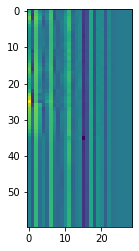

In [23]:
plt.imshow(train_data_drivertest[60:120,0:29])

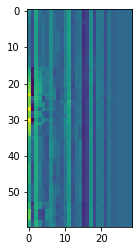

In [24]:
plt.imshow(train_data_driver[60:120,0:29])

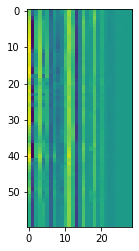

In [25]:
plt.imshow(test_data1[60:120,0:29])

In [26]:
def make_generator_model():
    model = tf.keras.Sequential()
#     model.add(layers.Dense(height*width, use_bias=False, input_shape=(height,width)))

    model.add(layers.Reshape((height, width,1), input_shape=(height,width)))
    
    # Layer 2: Hint use layers.Conv2DTranspose with 5x5 kernels and appropriate stride
    
#,activation = 'elu'
    
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.5,input_shape=[height, width,1]))
#     # Layer 3
    
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.5,input_shape=[height, width,1]))
    
    model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.5,input_shape=[height, width,1]))
    
    model.add(layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.5,input_shape=[height, width,1]))
    #Layer4
    
    model.add(layers.Reshape((height, width)))
    #model.add(layers.LSTM(16, input_length=height, input_dim=width, return_sequences=True))
#     model.add(layers.Dropout(0.5,input_shape=[height, width]))
    model.add(layers.LSTM(8, input_length=height, input_dim=width, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(width)))
#     model.add(layers.Reshape((height, width,1)))
#     model.add(layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same', use_bias=False))
#     assert model.output_shape == (None, height*4, width*4, 1)

    return model

In [27]:
# def make_generator_model():
#   model = tf.keras.Sequential()
# #   model.add(layers.GRU(128, input_length=height, input_dim=width, return_sequences=True))
# #   model.add(layers.Dropout(0.3))
#   model.add(layers.LSTM(32, input_length=height, input_dim=width, return_sequences=True))
# #   model.add(layers.Dropout(0.3))
#   model.add(layers.LSTM(16, input_length=height, input_dim=width, return_sequences=True))
# #   model.add(layers.Dropout(0.3))
#   model.add(layers.TimeDistributed(layers.Dense(width)))
#   model.add(layers.Reshape((height, width,1)))
#   return model

In [28]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 29, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 29, 128)       1152      
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 29, 128)       512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30, 29, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 29, 64)        73728     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 29, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 30, 29, 64)        0

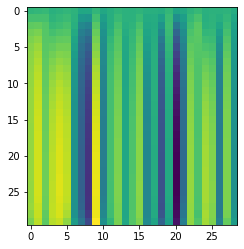

In [29]:
# noise = tf.random.normal([1,height,width])
# noise = tf.random.normal([32, height,width],0.007,0.5)
test = np.reshape(dataD_test[1],[1,dataD_test[1].shape[0],dataD_test[1].shape[1]])
generated_image = generator(test, training=False)
generated_image_a = np.reshape(generated_image[0],[height,width])
plt.imshow(generated_image_a[ :, :])

In [30]:
generated_image.shape

TensorShape([1, 30, 29])

In [31]:
np.min(generated_image_a)

-0.075565934

In [32]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
#     model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same',input_shape=[height, width, 1]))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    
#     model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
# #     model.add(layers.Dropout(0.1))

#     model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
# #     model.add(layers.Dropout(0.1))

#     model.add(layers.Conv2D(1, (3, 3), strides=(1, 1), padding='same'))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    
#     model.add(layers.Reshape((height, width)))
#     model.add(layers.LSTM(32, input_length=height, input_dim=width, return_sequences=True))
#     model.add(layers.Dropout(0.5,input_shape=[height, width]))
    model.add(layers.LSTM(16, input_length=height, input_dim=width, return_sequences=True))
#     model.add(layers.Dropout(0.3))
    model.add(layers.LSTM(8, input_length=height, input_dim=width, return_sequences=True))
#     model.add(layers.Dropout(0.3))
#     model.add(layers.LSTM(1, input_length=height, input_dim=width, return_sequences=True))
    model.add(layers.Flatten())
#     model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1))

    return model

In [33]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 16)            2944      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 8)             800       
_________________________________________________________________
flatten (Flatten)            (None, 240)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 241       
Total params: 3,985
Trainable params: 3,985
Non-trainable params: 0
_________________________________________________________________


In [34]:
generated_image_a=np.reshape(dataD_test[13927],[1,height,width])
decision = discriminator(generated_image_a)
print (decision)

tf.Tensor([[-0.07799952]], shape=(1, 1), dtype=float32)


In [35]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [36]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = (real_loss*1) + (fake_loss*1)
    return total_loss

In [37]:
def generator_loss(fake_output):
    generator_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return generator_loss

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [39]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [14]:
EPOCHS = 50
noise_dim = height*width
num_examples_to_generate = 16 # For visualization

# We will reuse this noise_vector overtime (so it's easier)
# to visualize progress in the animated GIF)
# noise_vector = tf.random.normal([num_examples_to_generate, height*width])
noise_vector = np.reshape(dataD_test[0:16,:,:],[16,dataD_test[0].shape[0],dataD_test[0].shape[1]])

NameError: name 'dataD_test' is not defined

In [41]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :])
      plt.axis('off')

  plt.savefig('./combine_picture/plot/image_at_'+str(epoch)+'_'+owner+'.png')
  plt.show()

In [42]:
def accuracy(score):
    acc = accuracy_score(labelD_test, score)
    return acc

In [43]:
def plot_acc(acc):
    arrange=np.arange(0, len(acc), 1, dtype=np.int32)
    plt.figure(figsize=(14,5),dpi=100,linewidth = 4)
    plt.plot(arrange,acc,'b', c='red',label = "acc")
    plt.xlabel("Time(s)", fontsize=10, labelpad = 15)
    plt.ylabel("fuel comsumption", fontsize=10, labelpad = 20)
    plt.legend(loc = "best", fontsize=10)
    plt.savefig('./combine_picture/plot/image_at_acc_'+owner+'.png')
    plt.show()

In [44]:
# def evaluate():    
#     score = np.empty([labelD_test.shape[0]])
#     for i in range(len(dataD_test)):
#         a=0
#         test = np.reshape(dataD_test[i],[1,dataD_test[i].shape[0],dataD_test[i].shape[1]])
#         d=discriminator(test)
#         if d > 0:
#             a=0
#         else:
#             a=1
#         score[i]=a
#     return score
# def evaluate():    
#     score = np.empty([labelD_test.shape[0]])
#     for i in range(len(dataD_test)):
#         test = np.reshape(dataD_test[i],[1,dataD_test[i].shape[0],dataD_test[i].shape[1]])
#         test_a = np.reshape(test,[height,width])
#         generated_image=generator(test, training=False)
#         generated_image_a = np.reshape(generated_image,[height,width])
#         a=mean_squared_error(test_a, generated_image_a)
#         score[i]=a
#     return score
def evaluate():    
    score = np.empty([labelD_test.shape[0]])
    for i in range(len(dataD_test)):
        a=0
        test = np.reshape(dataD_test[i],[1,dataD_test[i].shape[0],dataD_test[i].shape[1]])
        d=discriminator(test)
        score[i]=d
    return score

In [45]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
#     noise = tf.random.normal([BATCH_SIZE, height*width])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      # Generator output
        generated_images = generator(images, training=True)
      # Discriminator output
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True) 
      
      # Loss functions
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
  
    # Gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Update both networks
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [46]:
def train(dataset, epochs):
      score1 = np.empty([labelD_test.shape[0]])
      gen_loss =np.empty([EPOCHS])
      disc_loss =np.empty([EPOCHS])
      acc = np.zeros([int(EPOCHS/epoch_dura)])

      for epoch in range(epochs):
        start = time.time()
        if epoch%epoch_dura ==0:
            score = evaluate()
            score1 = np.vstack((score1,score))
#             acc[int(epoch/epoch_dura)] = accuracy(score)
#             plot_acc(acc)
#             print(acc)

        for image_batch in dataset:
            gen_loss[epoch],disc_loss[epoch]=train_step(image_batch)


        # Produce images for the GIF as we go
#         display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 noise_vector)

        # Save the model every 15 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

      # Generate after the final epoch
#         display.clear_output(wait=True)
        generate_and_save_images(generator,
                               epochs,
                               noise_vector)
      np.save("./combine_score/score_owner"+owner+".npy", score1)
      np.save("./combine_loss/gloss_owner"+owner+".npy", gen_loss)
      np.save("./combine_loss/dloss_owner"+owner+".npy", disc_loss)

In [47]:
# BUFFER_SIZE = 60000
BATCH_SIZE = 128
dataD_train=dataD_train.astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(dataD_train).shuffle(dataD_train.shape[0]).batch(BATCH_SIZE)

In [48]:
dataD_train.shape

(6591, 30, 29)

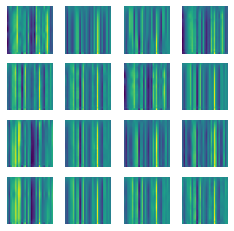

Time for epoch 1 is 189.1428427696228 sec


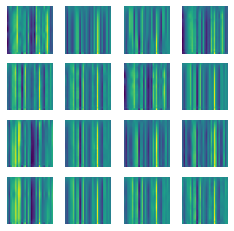

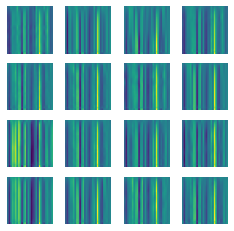

Time for epoch 2 is 181.1270613670349 sec


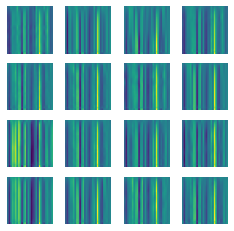

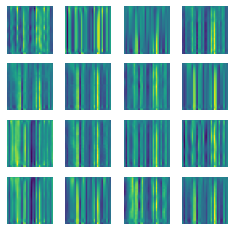

Time for epoch 3 is 181.41822934150696 sec


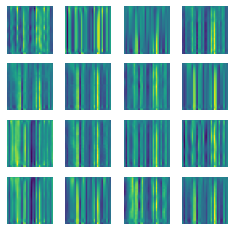

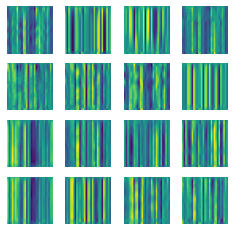

Time for epoch 4 is 181.21946477890015 sec


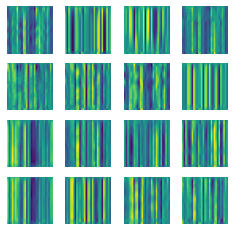

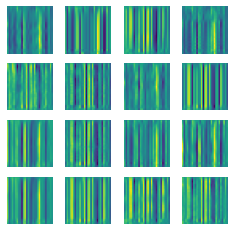

Time for epoch 5 is 182.32332706451416 sec


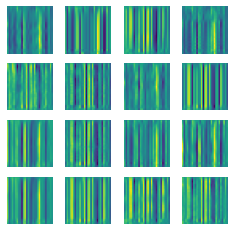

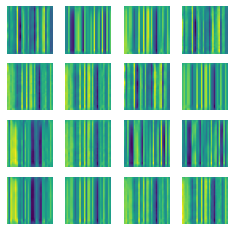

Time for epoch 6 is 183.1922950744629 sec


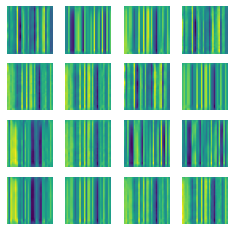

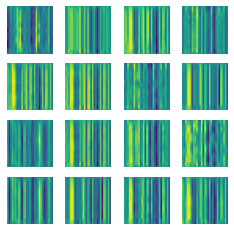

Time for epoch 7 is 182.88370084762573 sec


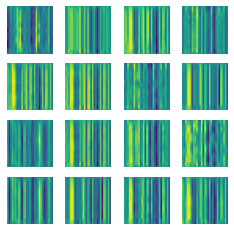

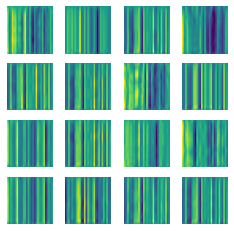

Time for epoch 8 is 183.000741481781 sec


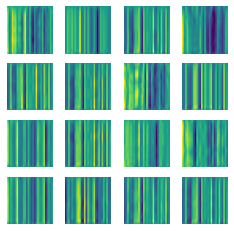

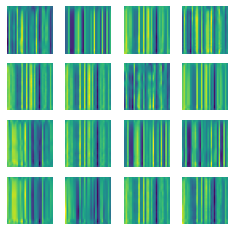

Time for epoch 9 is 183.33886909484863 sec


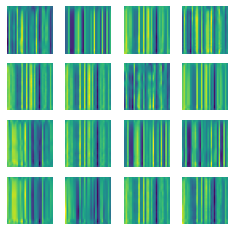

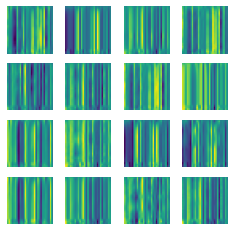

Time for epoch 10 is 183.34950494766235 sec


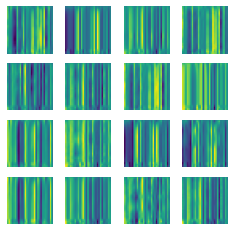

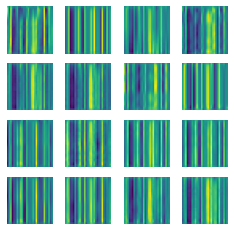

Time for epoch 11 is 183.02567648887634 sec


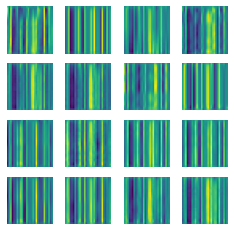

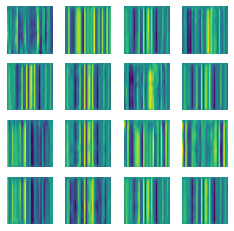

Time for epoch 12 is 183.5596945285797 sec


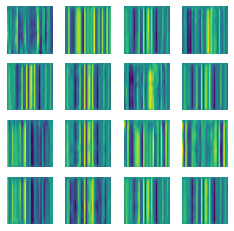

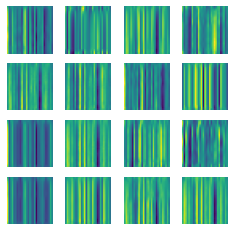

Time for epoch 13 is 183.2176547050476 sec


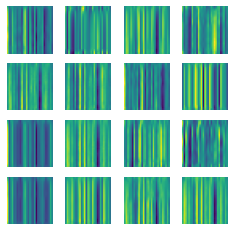

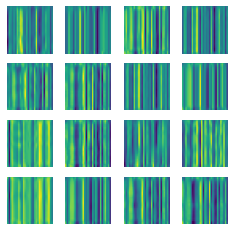

Time for epoch 14 is 183.14244484901428 sec


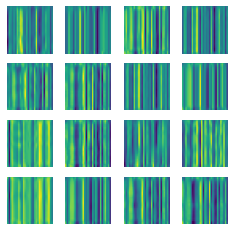

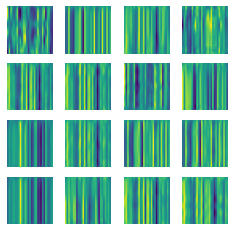

Time for epoch 15 is 182.5250928401947 sec


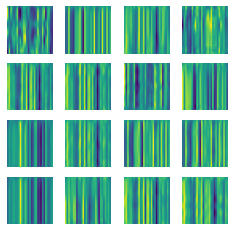

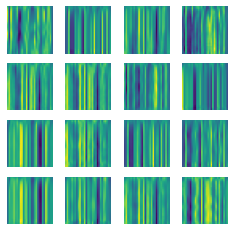

Time for epoch 16 is 182.7411961555481 sec


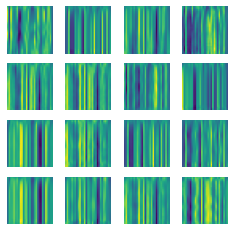

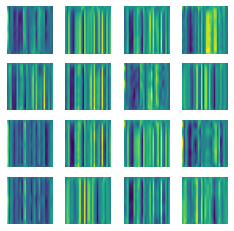

Time for epoch 17 is 182.75700044631958 sec


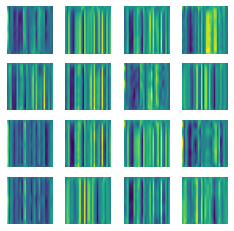

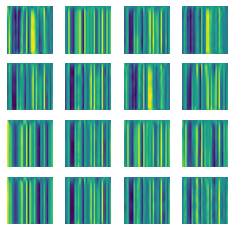

Time for epoch 18 is 182.88605618476868 sec


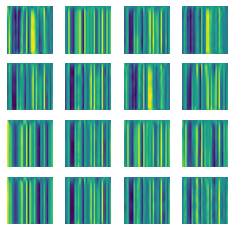

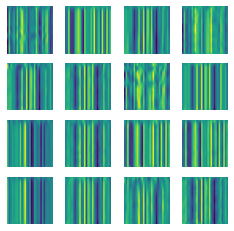

Time for epoch 19 is 182.05885362625122 sec


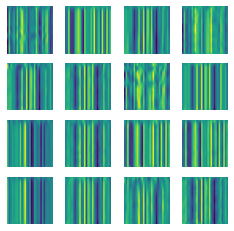

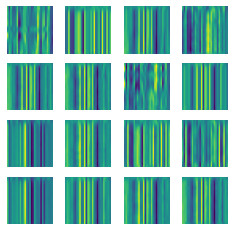

Time for epoch 20 is 182.68788838386536 sec


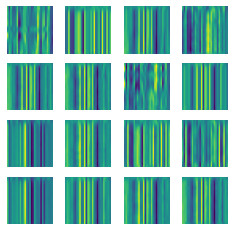

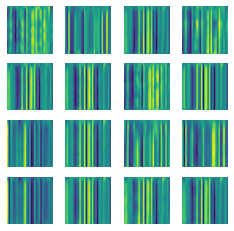

Time for epoch 21 is 183.18236422538757 sec


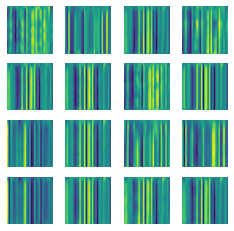

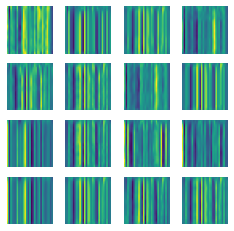

Time for epoch 22 is 183.8783073425293 sec


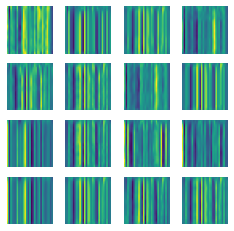

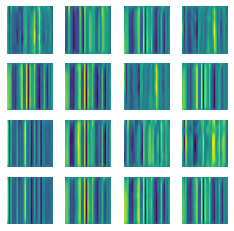

Time for epoch 23 is 183.2532274723053 sec


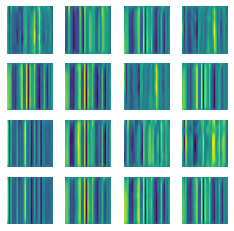

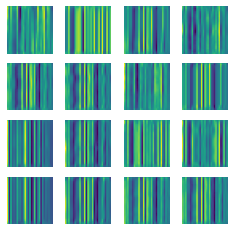

Time for epoch 24 is 182.017422914505 sec


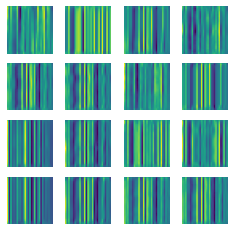

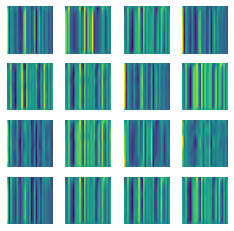

Time for epoch 25 is 182.52592396736145 sec


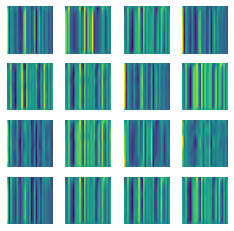

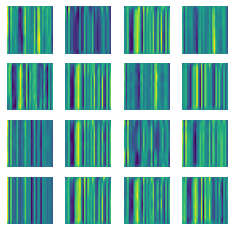

Time for epoch 26 is 181.0876579284668 sec


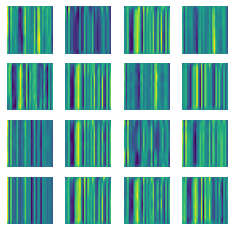

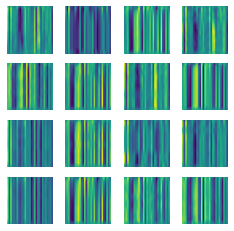

Time for epoch 27 is 181.54380989074707 sec


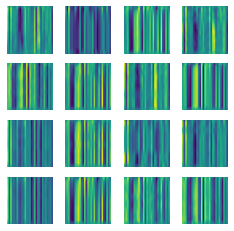

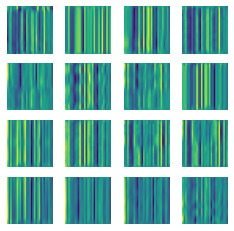

Time for epoch 28 is 181.47835421562195 sec


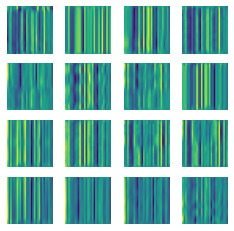

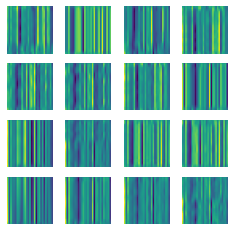

Time for epoch 29 is 181.5210862159729 sec


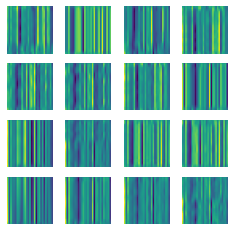

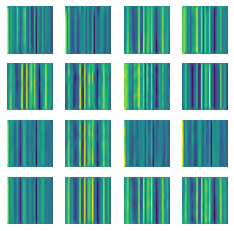

Time for epoch 30 is 181.3932123184204 sec


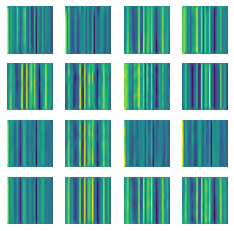

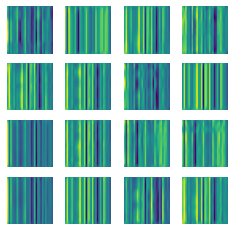

Time for epoch 31 is 181.18142080307007 sec


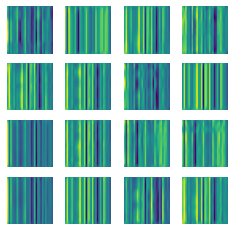

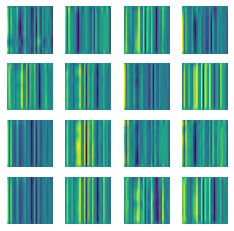

Time for epoch 32 is 180.9947431087494 sec


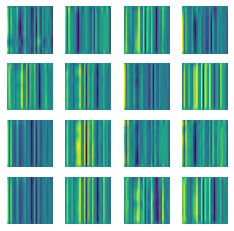

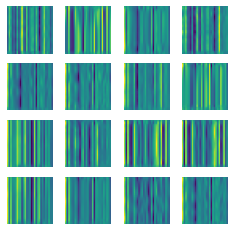

Time for epoch 33 is 181.97663974761963 sec


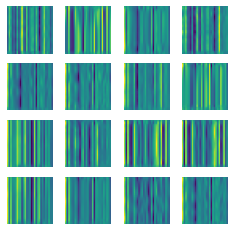

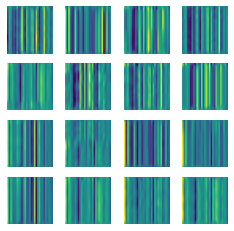

Time for epoch 34 is 182.15054178237915 sec


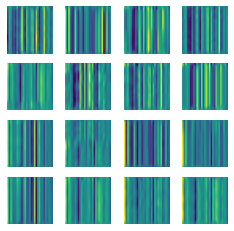

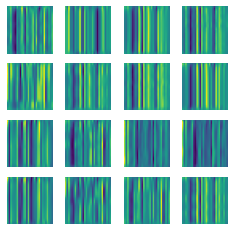

Time for epoch 35 is 181.31185579299927 sec


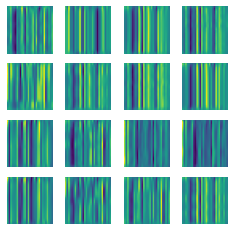

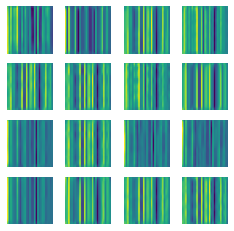

Time for epoch 36 is 181.843252658844 sec


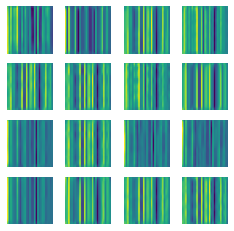

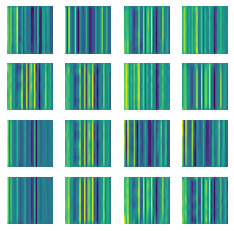

Time for epoch 37 is 181.2562770843506 sec


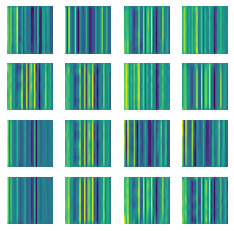

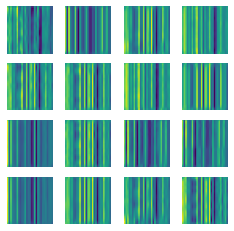

Time for epoch 38 is 182.10360193252563 sec


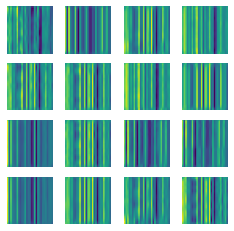

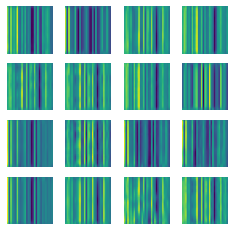

Time for epoch 39 is 181.38789653778076 sec


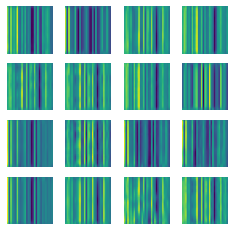

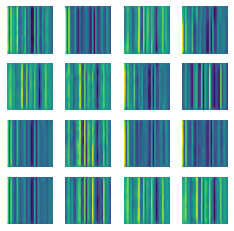

Time for epoch 40 is 181.2678496837616 sec


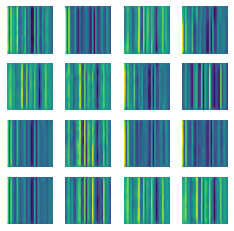

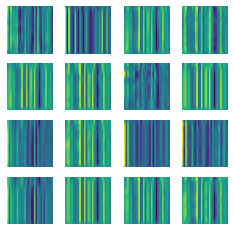

Time for epoch 41 is 181.2585427761078 sec


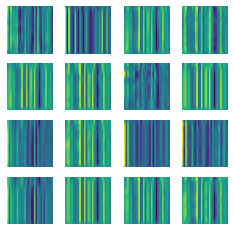

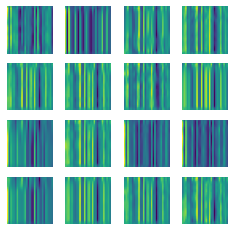

Time for epoch 42 is 181.35278248786926 sec


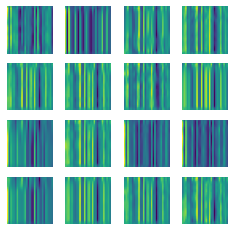

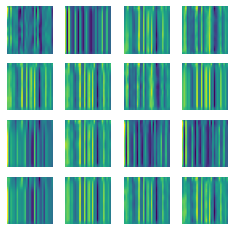

Time for epoch 43 is 181.33635568618774 sec


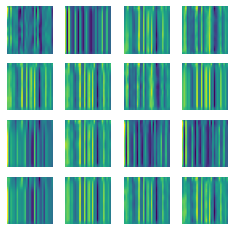

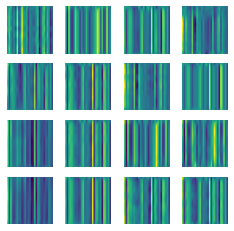

Time for epoch 44 is 181.58113956451416 sec


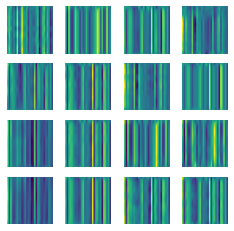

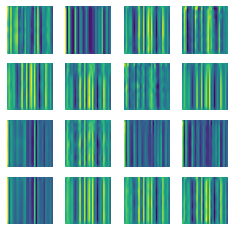

Time for epoch 45 is 181.3585569858551 sec


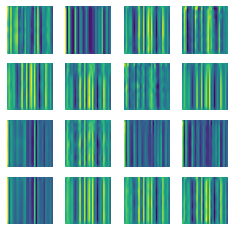

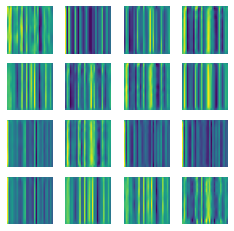

Time for epoch 46 is 181.68213319778442 sec


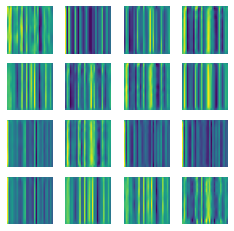

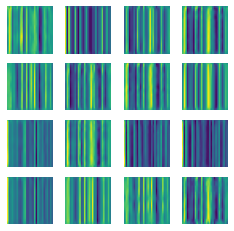

Time for epoch 47 is 181.8519003391266 sec


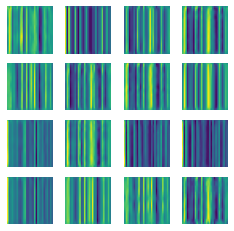

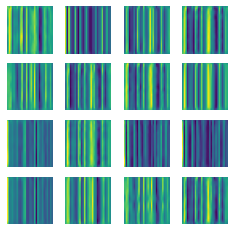

Time for epoch 48 is 181.01209139823914 sec


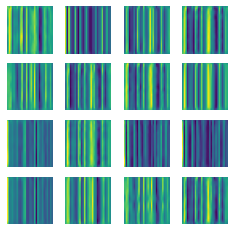

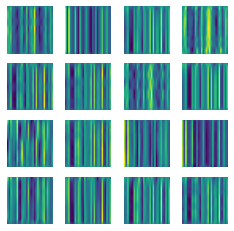

Time for epoch 49 is 181.29249024391174 sec


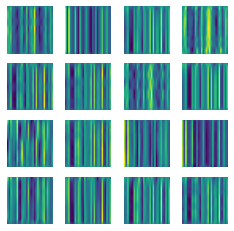

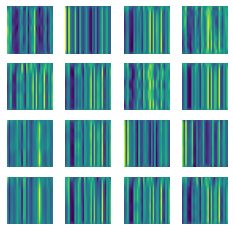

Time for epoch 50 is 181.94779467582703 sec


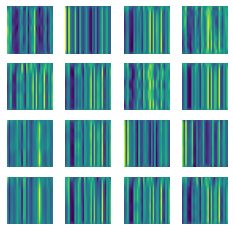

Wall time: 2h 32min 10s


In [49]:
%%time
train(train_dataset, EPOCHS)

In [10]:
score1=np.load('./combine_score/score_owner'+owner+'.npy',allow_pickle=True)
labelD_test=np.load('./combine_score/label_owner'+owner+'.npy',allow_pickle=True)
gen_loss=np.load('./combine_loss/gloss_owner'+owner+'.npy', allow_pickle=True)
disc_loss=np.load('./combine_loss/dloss_owner'+owner+'.npy', allow_pickle=True)

In [11]:
score1.shape

(51, 34185)

In [12]:
D_L = np.empty([score1.shape[1]])
precision = np.empty([score1.shape[0]-1])
recall = np.empty([score1.shape[0]-1])
f1 = np.empty([score1.shape[0]-1])
acc = np.empty([score1.shape[0]-1])
for j in range (score1.shape[0]-1):
    for i in range(score1.shape[1]):
        if score1[j+1][i]>(0):
            # true/negative
            D_L[i] = 0
        else:
            # false/positive
            D_L[i] = 1
    precision[j], recall[j], f1[j], _ = precision_recall_fscore_support(labelD_test, D_L, average='binary')
    acc[j] = accuracy_score(labelD_test, D_L)

In [53]:
# score = np.empty([labelD_test.shape[0]])
# for i in range(len(dataD_test)):
#     test = np.reshape(dataD_test[i],[1,dataD_test[i].shape[0],dataD_test[i].shape[1]])
#     test_a = np.reshape(test,[height,width])
#     generated_image=generator(test, training=False)
#     generated_image_a = np.reshape(generated_image,[height,width])
#     a=ssim(test_a, generated_image_a)
#     score[i]=a

In [54]:
# np.min(score1[19])

In [55]:
# print ('Time for epoch {} is {} sec'.format(1, time.time()-start))

In [56]:
# precision = np.empty([score1.shape[0]-1])
# recall = np.empty([score1.shape[0]-1])
# f1 = np.empty([score1.shape[0]-1])
# acc = np.empty([score1.shape[0]-1])
# for i in range (score1.shape[0]-1):
#     precision[i], recall[i], f1[i], _ = precision_recall_fscore_support(labelD_test, score1[i+1],pos_label=1, average='binary')
#     acc[i] = accuracy_score(labelD_test, score1[i+1])

In [57]:
# precision, recall, f1, _ = precision_recall_fscore_support(labelD_test, score1[6], average='binary')

In [58]:
# D_L.shape

In [59]:
# b=16
# a=0
# for i in range (len(score1[b])):
#     if score1[b][i]==0:
#         if +labelD_test[i]==0:
#             a=a+1
# a

In [60]:
a=0
b=0
c=3
for i in range (len(score1[c])):
    if score1[c][i]<=0.15:
        a = a + score1[c][i]
        b=b+1
a=a/b
a

0.015802105984064018

In [61]:
acc

array([0.73055434, 0.75533129, 0.4850958 , 0.38051777, 0.41842914,
       0.43027644, 0.6248062 , 0.71671786, 0.77776803, 0.81266637,
       0.97270733, 0.97706596, 0.95811028, 0.99809858, 0.99976598,
       0.99979523, 0.99973673, 0.99953196, 1.        , 0.99973673,
       0.99982448, 0.96884599, 0.97431622, 0.97592511, 0.97820682,
       0.97621764, 0.97487202, 0.97504754, 0.97203452, 0.98160012,
       0.97595437, 0.98303349, 0.96700307, 0.90337867, 0.96697382,
       0.99502706, 0.94164107, 0.96372678, 0.96270294, 0.9403247 ,
       0.94360099, 0.92534737, 0.93690215, 0.96311248, 0.94330847,
       0.92514261, 0.93453269, 0.94836917, 0.95354688, 0.94611672])

In [62]:
precision

array([0.88728299, 0.99312715, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99942048, 1.        , 0.99967394,
       0.9997826 , 0.9628376 , 0.9691616 , 0.97103744, 0.97371021,
       0.97137929, 0.9698088 , 0.97001336, 0.96651371, 0.97771242,
       0.97107162, 0.97941291, 0.9607256 , 0.89309296, 0.96069215,
       0.99387674, 0.93257402, 0.95699372, 0.95583345, 0.93115783,
       0.93469056, 0.91534251, 0.9274958 , 0.95629722, 0.9370677 ,
       0.91513001, 0.92497737, 0.9398801 , 0.94754414, 0.93742144])

In [63]:
recall

array([0.76312833, 0.70173595, 0.36208459, 0.23252274, 0.27949118,
       0.29416881, 0.53517196, 0.64904142, 0.72467655, 0.76791215,
       0.96618708, 0.971587  , 0.94810278, 0.99764433, 0.99971007,
       0.99974631, 0.99967383, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99670206,
       1.        , 1.        , 1.        , 0.99768057, 1.        ])

In [64]:
f1

array([0.8205358 , 0.82238267, 0.53166241, 0.37731189, 0.43687863,
       0.45460655, 0.69721435, 0.78717419, 0.84036227, 0.86872207,
       0.98280279, 0.98558877, 0.97336012, 0.99882078, 0.99985501,
       0.99987314, 0.99983689, 0.99971016, 1.        , 0.99983694,
       0.99989129, 0.981067  , 0.98433933, 0.98530593, 0.98668002,
       0.98548188, 0.98467303, 0.98477846, 0.98297175, 0.98873063,
       0.98532353, 0.9895994 , 0.97996946, 0.94352784, 0.97995206,
       0.99692897, 0.96511079, 0.97802432, 0.97741804, 0.96435187,
       0.96624295, 0.95580034, 0.96238425, 0.97766046, 0.96596537,
       0.95568447, 0.96102675, 0.96900845, 0.97196625, 0.96770008])

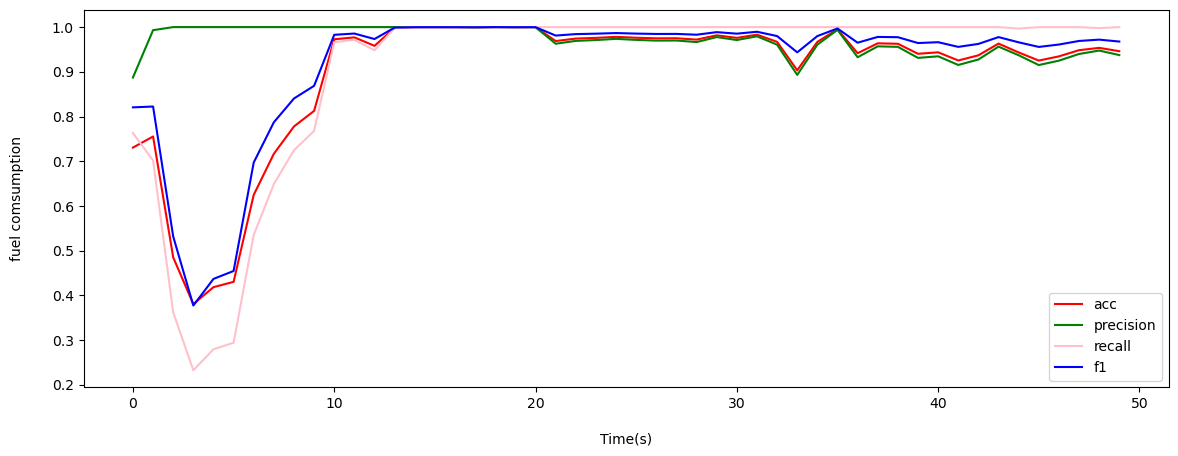

In [16]:
arrange=np.arange(0, EPOCHS, epoch_dura , dtype=np.int32)
plt.figure(figsize=(14,5),dpi=100,linewidth = 4)
plt.plot(arrange,acc,'b', c='red',label = "acc")
plt.plot(arrange,precision,'b', c='green',label = "precision")
plt.plot(arrange,recall,'b', c='pink',label = "recall")
plt.plot(arrange,f1,'b', c='blue',label = "f1")
# plt.plot(arrange,gen_loss,'b', c='green',label = "g_loss")
# plt.plot(arrange,disc_loss, 'b',c='pink',label = "d_loss")
plt.xlabel("Time(s)", fontsize=10, labelpad = 15)
plt.ylabel("fuel comsumption", fontsize=10, labelpad = 20)
plt.legend(loc = "best", fontsize=10)
# plt.savefig("./picture/driverA&D_fuel comsumption.png")

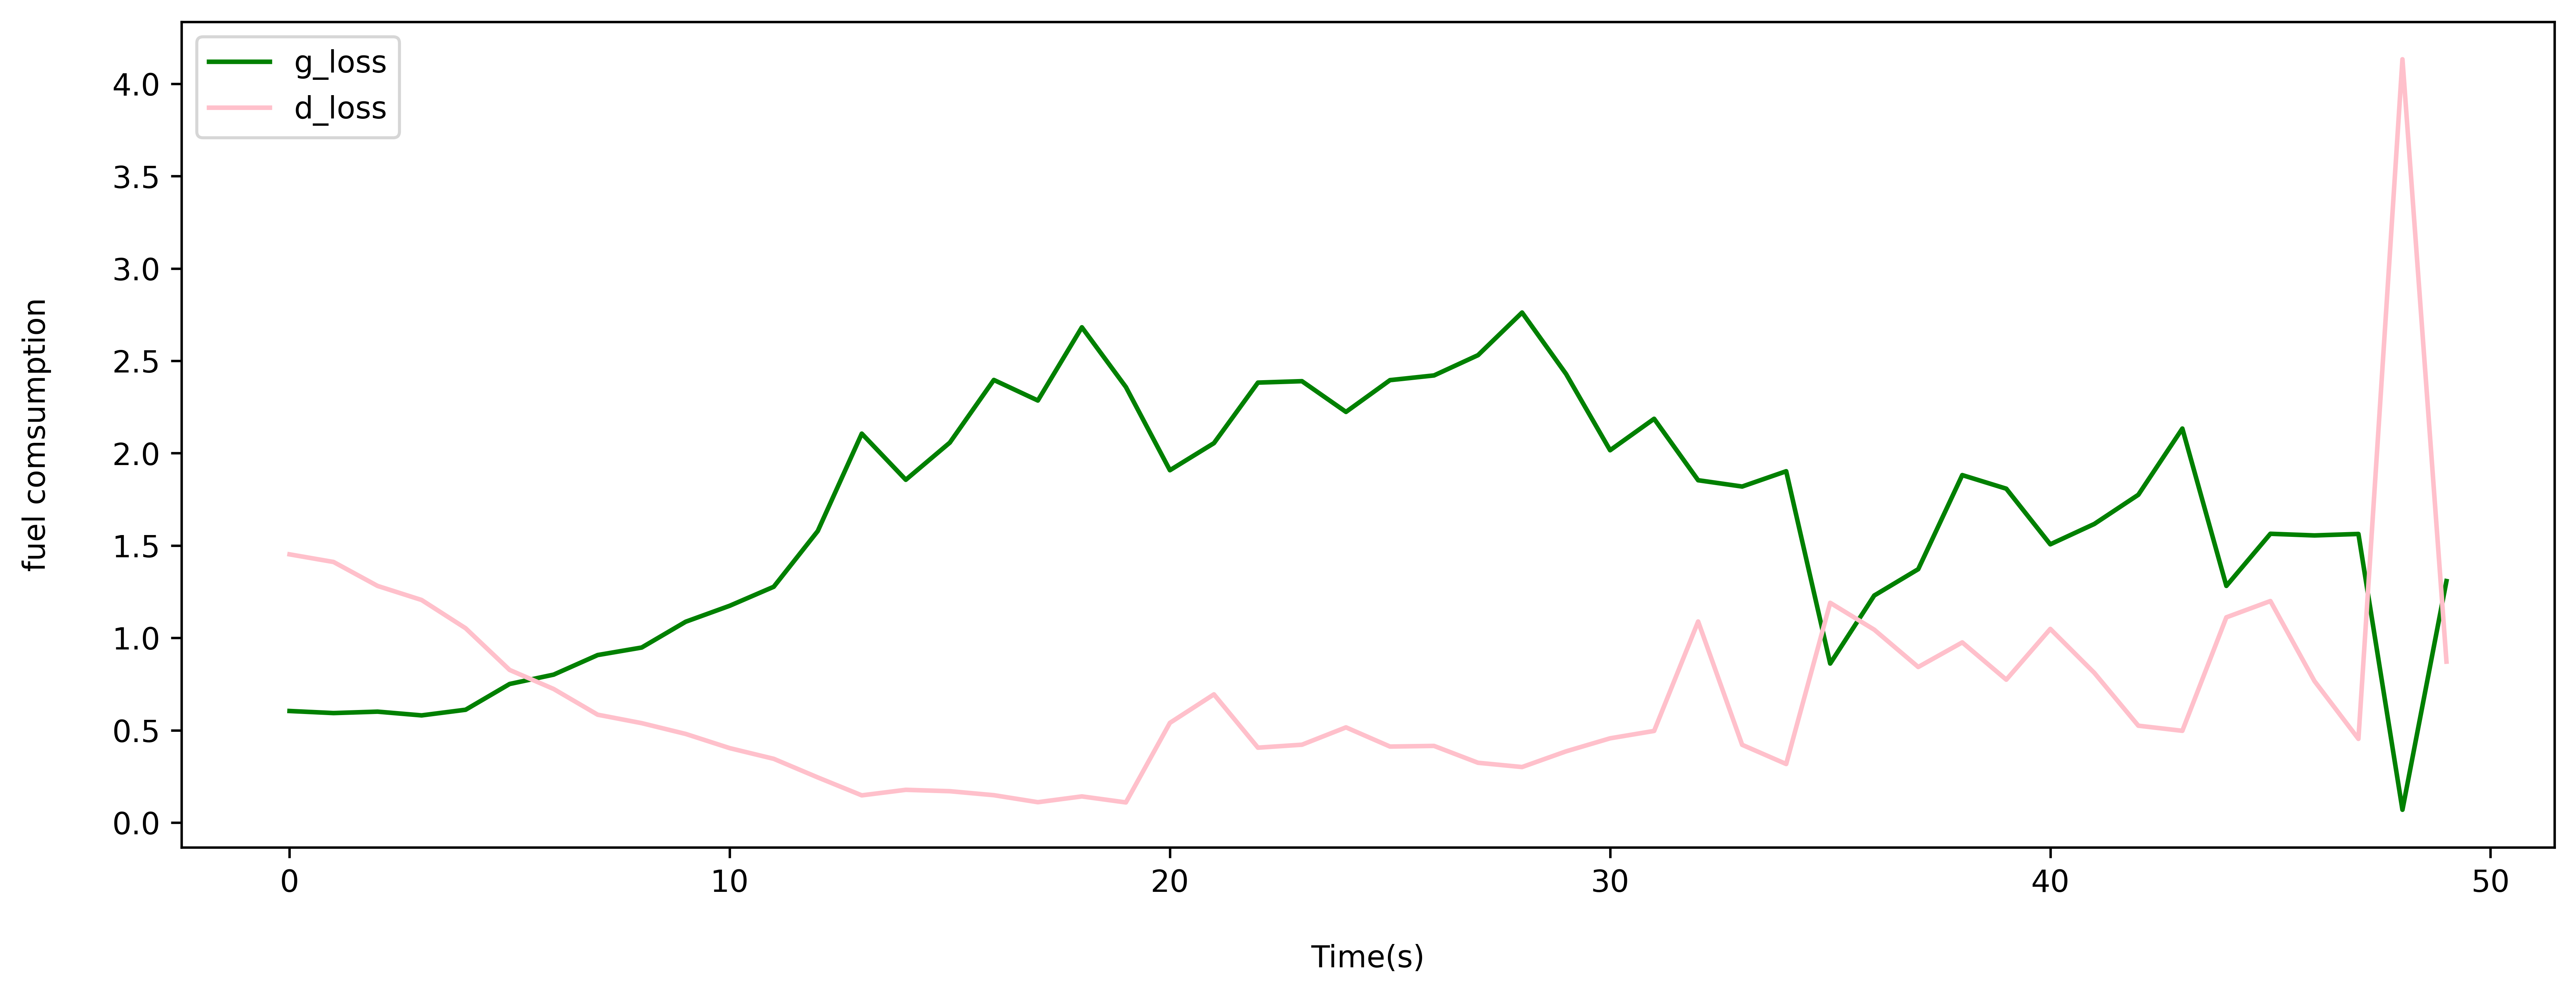

In [66]:
arrange1=np.arange(0, EPOCHS, 1, dtype=np.int32)
plt.figure(figsize=(14,5),dpi=600,linewidth = 4)
plt.plot(arrange1,gen_loss,'b', c='green',label = "g_loss")
plt.plot(arrange1,disc_loss, 'b',c='pink',label = "d_loss")
plt.xlabel("Time(s)", fontsize=10, labelpad = 15)
plt.ylabel("fuel comsumption", fontsize=10, labelpad = 20)
plt.legend(loc = "best", fontsize=10)
plt.savefig('./combine_picture/plot/image_at_loss_'+owner+'.pdf')